In [382]:
import pandas as pd
import numpy as np
import requests
import json
import sqlite3
import datetime
import seaborn as sns

Import bike station information.

In [383]:
url2='https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'
stationInfo_df = pd.DataFrame(json.loads(requests.get(url2).text)['data']['stations'])
stationInfo_df['station_id'] = stationInfo_df['station_id'].astype(np.int64)
stationInfo_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN
1,7001,Lower Jarvis St / The Esplanade,REGULAR,43.647992,-79.370907,0.0,Lower Jarvis St / The Esplanade,15,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],416-617-9576,500.0,NaN,NaN
2,7002,St. George St / Bloor St W,REGULAR,43.667333,-79.399429,0.0,St. George St / Bloor St W,19,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-643-9615,500.0,NaN,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667158,-79.402761,NaN,Madison Ave / Bloor St W,15,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-631-4587,500.0,NaN,NaN
4,7004,University Ave / Elm St,REGULAR,43.656518,-79.389099,NaN,University Ave / Elm St,11,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[P7004-7047],647-643-9673,500.0,NaN,NaN


Connect to the SQLite database. This contains a log of all station statuses that is recored every 10 minutes.

In [384]:
conn = sqlite3.connect('bikeshareTO.db')
c = conn.cursor()

Load the database into a pandas dataframe.

In [385]:
df = pd.read_sql_query(
    'SELECT * FROM station_status',conn)

I'm going to check which stations has the largest standard deviation as an indicator of activity.

In [386]:
busyStations_df = df[['station_id','num_bikes_available']].groupby(by='station_id').std().sort_values(by='num_bikes_available',ascending=False).head(20)
busyStations_df.join(stationInfo_df[['station_id','name']].set_index('station_id'))

,num_bikes_available,name
station_id,,
7344,13.272250,Cherry Beach
7047,9.437572,University Ave / Gerrard St W
7042,9.275926,Sherbourne St / Wellesley St E
7168,8.796632,Queens Quay / Yonge St
7015,8.386968,King St W / Bay St (West Side)
7037,8.381746,Bathurst St / Dundas St W
7000,7.784287,Fort York Blvd / Capreol Ct
7524,7.464258,Lisgar Park
7161,7.158575,Beverley St / College St


For Cherry Beach, the bikes begin to get rented around 12pm.


Text(0.5, 0, 'Date (M-D-Hour)')

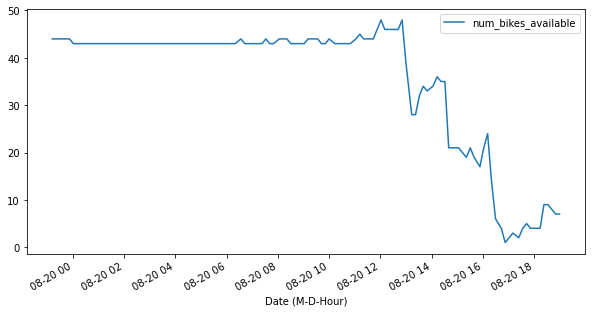

In [415]:
df = pd.read_sql_query(
    'SELECT * FROM station_status WHERE station_id=7344',conn)
df['last_reported'] = pd.to_datetime(df['last_reported'],unit='s') + pd.Timedelta(hours=-4)
ax = df.plot('last_reported','num_bikes_available',figsize=(10,5))
ax.set_xlabel('Date (M-D-Hour)')

For University Ave / Gerrard St W, the clear 8am-4pm work cycle is shown.

Text(0.5, 0, 'Date (M-D-Hour)')

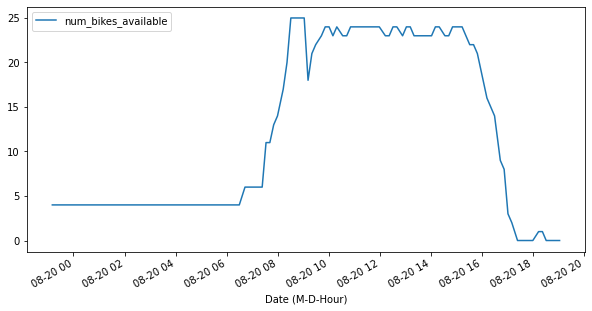

In [416]:
df = pd.read_sql_query(
    'SELECT * FROM station_status WHERE station_id=7047',conn)
df['last_reported'] = pd.to_datetime(df['last_reported'],unit='s') + pd.Timedelta(hours=-4)
ax = df.plot('last_reported','num_bikes_available',figsize=(10,5))
ax.set_xlabel('Date (M-D-Hour)')

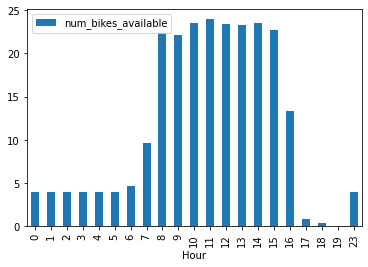

In [418]:
df['Hour'] = df['last_reported'].dt.hour
df.groupby(by='Hour').mean().reset_index().plot.bar('Hour','num_bikes_available')

I'm going to analyze the difference between bike availability before the beginning of the work cycle (4am-6am) and during the start of the work cycle (8am-10am). This will indicate where people are going.

In [390]:
df = pd.read_sql_query(
    'SELECT * FROM station_status',conn)
df['last_reported'] = pd.to_datetime(df['last_reported'],unit='s') + pd.Timedelta(hours=-4)
startHours = (df['last_reported']<'10:00:00') & (df['last_reported']>'8:00:00')
earlyHours = (df['last_reported']<'6:00:00') & (df['last_reported']>'4:00:00')
endHours = (df['last_reported']<'19:00:00') & (df['last_reported']>'17:00:00')
start_df = df[startHours].groupby(by='station_id').mean()
end_df = df[endHours].groupby(by='station_id').mean()
start_df

,num_bikes_available,num_bikes_disabled,num_docks_available
station_id,,,
7000,29.500000,0.000000,5.500000
7001,9.416667,0.000000,5.583333
7002,10.500000,0.000000,8.500000
7003,1.833333,1.916667,11.250000
7004,10.833333,0.166667,0.000000
...,...,...,...
7640,0.000000,0.000000,15.000000
7641,6.000000,0.000000,9.000000
7642,0.416667,0.000000,18.583333


In [391]:
early_df = df[earlyHours].groupby(by='station_id').mean()
early_df

,num_bikes_available,num_bikes_disabled,num_docks_available
station_id,,,
7000,33.0,0.0,2.0
7001,14.0,0.0,1.0
7002,0.0,0.0,19.0
7003,4.0,1.0,10.0
7004,4.0,0.0,7.0
...,...,...,...
7640,0.0,0.0,15.0
7641,6.0,0.0,9.0
7642,2.0,0.0,17.0


I'll subtract the results of the dataframes to get the average change in bike availabilty at each station. I divide the result by the capacity to normalize the results.

In [392]:
diff_df = (start_df - early_df).sort_values(by='num_bikes_available').join(stationInfo_df.set_index('station_id')[['name','capacity','lat','lon']])
diff_df['normalized_change'] = np.rint(diff_df['num_bikes_available']/ diff_df['capacity']*100)
diff_df = diff_df.sort_values(by='normalized_change')
diff_df

,num_bikes_available,num_bikes_disabled,num_docks_available,name,capacity,lat,lon,normalized_change
station_id,,,,,,,,
7017,-7.903846,0.000000,7.903846,Widmer St / Adelaide St W,11,43.647508,-79.391484,-72.0
7054,-7.384615,0.000000,7.384615,Navy Wharf Ct. / Bremner Blvd.,11,43.640722,-79.391051,-67.0
7168,-20.141026,0.000000,20.141026,Queens Quay / Yonge St,31,43.641646,-79.375308,-65.0
7278,-9.500000,0.000000,9.500000,Mallon Ave / Jones Ave -SMART,16,43.665870,-79.334430,-59.0
7525,-4.000000,0.000000,4.000000,Fennings St / Queen St W - SMART,7,43.643945,-79.421189,-57.0
...,...,...,...,...,...,...,...,...
7062,7.500000,0.000000,-7.500000,University Ave / College St (West),11,43.659226,-79.390213,68.0
7026,10.500000,1.000000,-11.500000,Bay St / St. Joseph St,15,43.665527,-79.387499,70.0
7047,18.272727,0.363636,-18.636364,University Ave / Gerrard St W,25,43.657763,-79.389165,73.0


## Map
I'll plot the results on a Folium map, where the red data points indicate stations that had a deficit of bikes and the green points represent the stations that had a surplus of bikes. The size of the markers represents the magnitude of the normalized change.

We can clearly see that the green (surplus) data points are centralized whereas the deficit are outside the downtown core and outskirts. The surplus is mainly clustered on University Avenue near the hospitals, and on Bay street by the Financial district.

In [393]:
import folium

m = folium.Map(location=[43.650033,-79.396555])
diff_df[diff_df['normalized_change']<=-5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#FF0000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                          tooltip=row['name']+"<br>Capacity Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)

diff_df[diff_df['normalized_change']>=5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#008000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                         tooltip=row['name']+"<br>Capacity Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)
m

I'll do a similar analysis comparing the end of work hours (5pm-7pm) compared to the start of work hours (8am-10am). 

In [396]:
diff_df = (end_df - start_df).sort_values(by='num_bikes_available').join(stationInfo_df.set_index('station_id')[['name','capacity','lat','lon']])
diff_df['normalized_change'] = np.rint(diff_df['num_bikes_available']/ diff_df['capacity']*100)
diff_df = diff_df.sort_values(by='normalized_change')
diff_df

,num_bikes_available,num_bikes_disabled,num_docks_available,name,capacity,lat,lon,normalized_change
station_id,,,,,,,,
7502,-12.616162,0.000000,12.616162,University Ave / College St (East),14,43.659950,-79.389640,-90.0
7047,-21.494949,1.636364,19.858586,University Ave / Gerrard St W,25,43.657763,-79.389165,-86.0
7004,-9.166667,0.833333,8.333333,University Ave / Elm St,11,43.656518,-79.389099,-83.0
7344,-39.388889,0.000000,39.388889,Cherry Beach,49,43.637764,-79.345359,-80.0
7163,-11.529915,1.000000,10.529915,Yonge St / Wood St,15,43.662222,-79.382500,-77.0
...,...,...,...,...,...,...,...,...
7153,9.388889,0.000000,-9.388889,Bloor St W / Christie St,19,43.663889,-79.418889,49.0
7063,9.416667,0.000000,-9.416667,Queen's Park / Bloor St W,19,43.668456,-79.393899,50.0
7409,10.888889,0.000000,-10.888889,Isabella St / Church St,19,43.668340,-79.382350,57.0


We can start to see some green points on the outskirts indicating that people are leaving work. A significant deficit is seen on University Ave as well.

In [397]:
m = folium.Map(location=[43.650033,-79.396555])
diff_df[diff_df['normalized_change']<=-5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#FF0000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                          tooltip=row['name']+"<br>Capacity Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)

diff_df[diff_df['normalized_change']>=5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#008000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                         tooltip=row['name']+"<br>Capacity Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)
m